# Домашнее задание "Варианционные автоэнкодеры"

Выполнил студент группы  Груданов Николай Алексеевия

В этом домашнем задании вам предстоит реализовать VAE для датасета картинок MNIST.

Вы научитесь обучать вариационный автоэнкодер (VAE) генерировать новые изображения с нуля. А также сможете управлять генерацией, указывая желаемый класс объекта, и оценивать качество результата с помощью метрики FID.

Это домашнее задание состоит из двух частей:

* **I часть.** Реализовать безусловную генерацию картинок при помощи VAE тренированную на датасете MNIST и оценить качество по метрике FID.
* **II часть.** Реализовать условную генерацию по классу и оценить качество по метрике FID.
    

Установите библиотеку для подсчета FID:

In [8]:
#!pip install pytorch-fid

In [9]:
import torch
import importlib.metadata

print(f"PyTorch: {torch.__version__}")
print(f"ROCm/HIP: {torch.version.hip}")
print(f"pytorch-fid: {importlib.metadata.version('pytorch-fid')}")

# Проверка доступности GPU
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


PyTorch: 2.5.1+rocm6.2
ROCm/HIP: 6.2.41133-dd7f95766
pytorch-fid: 0.3.0
GPU available: True
GPU: AMD Radeon RX 7800 XT


## **I часть. Unconditional VAE (6 баллов)**

### Библиотеки

In [10]:
# TODO
# Импортните любые необходимые вам библиотеки
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torch
import os
import random
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import copy

### Датасет.

**Задание**: Скачайте датасет MNIST и подготовьте train dataloader.

In [11]:
train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transforms.Compose([
        transforms.ToTensor(), # [0.0, 1.0] float
        transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
        ])
    )

train_loader = DataLoader(
        train_dataset,
        batch_size=512,
        shuffle=True
    )

test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), # [0.0, 1.0] float
        transforms.Lambda(lambda x: (x > 0.5).float()) # Binarize
    ])
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.42MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 248kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.01MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.20MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**Задание**: Для FID сохраните 10k реальных изображений из MNIST test части в папку

In [12]:
# TODO: Для FID сохраните 10k реальных изображений из MNIST test части в папку

os.makedirs('mnist_vae_real', exist_ok=True)

for i in range(len(test_dataset)):
    img, _ = test_dataset[i]
    save_image(img, f'mnist_vae_real/real_{i:05d}.png')

**Задание**: Визуализируйте 5 рандомных сэмплов из тренировочных данных и 5 сэмплов из тестовых данных

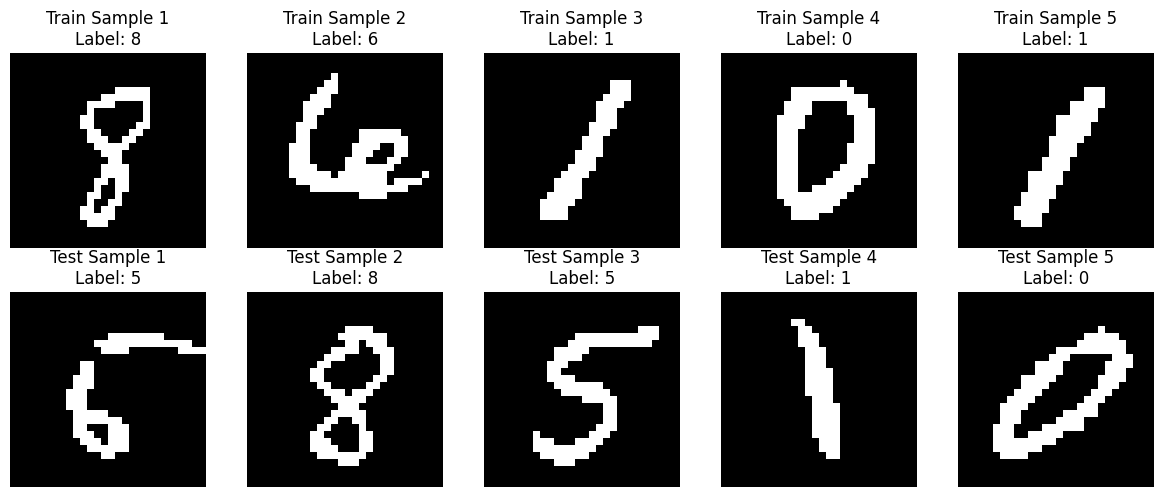

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    id = random.randint(0, len(train_dataset) - 1)
    img, label = train_dataset[id]
    axes[0, i].imshow(img[0], cmap='gray')
    axes[0, i].set_title(f'Train Sample {i+1}\nLabel: {label}')
    axes[0, i].axis('off')

for i in range(5):
    id = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[id]
    axes[1, i].imshow(img[0], cmap='gray')
    axes[1, i].set_title(f'Test Sample {i+1}\nLabel: {label}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

### Модель

**Задание**: Реализуйте VAE архитектуру

In [14]:
# TODO: Реализуйте VAE (безусловный)

class VAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        # Encoder: изображение -> mu, logvar
        # Decoder: z -> изображение

        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, 4, 2, 1),  # понизим размерность изображения до 14 на 14
            nn.ReLU(), # добавляем нелинейность
            nn.Conv2d(32, 64, 4, 2, 1), # понизим размерность изображения до 7 на 7
            nn.ReLU(), # добавляем нелинейность
            nn.Flatten(), # вытягиваем в одномерный вектор
            nn.Linear(3136, hidden_dim), # делаем вектор с 128 координатами из вектора с 3136 координатами
            nn.ReLU(), # добавляем нелинейность
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), # делаем вектор с 128 координатами из вектора с 32 координатами
            nn.ReLU(), # добавляем нелинейность
            nn.Linear(hidden_dim, 3136), # делаем вектор с 3136 координатами из вектора с 128 координатами
            nn.ReLU(), # добавляем нелинейность
            nn.Unflatten(1, (64, 7, 7)), # делаем 4D-тензор
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # повышаем размерность изображения до 14 на 14
            nn.ReLU(), # добавляем нелинейность
            nn.ConvTranspose2d(32, input_dim, 4, 2, 1), # повышаем размерность изображения до 28 на 28
            nn.Sigmoid() # ф-я активации, которая предсказывает класс пикселя
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z)
        return p_recon, mu, logvar, z

### Loss

**Задание**: Напишите VAE Loss

In [15]:
# TODO: Реализуйте функцию потерь VAE (подходит и для CVE)

def vae_loss(p_recon, x, mu, logvar):
    # Reconstruction loss: BCE (since output is sigmoid)
    recon_loss = F.binary_cross_entropy(p_recon, x, reduction='sum')
    # KL divergence: D_KL(q(z|x) || p(z))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss, recon_loss, kl_loss

### Тренировка

**Задание**: Обучите модель на датасете MNIST.

In [16]:
latent_dim = 32 # MNIST VAEs often use 20–64
hidden_dim = 128
epochs = 25
lr = 1e-3
img_size = 28
channels = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [17]:
if torch.cuda.is_available():
    print(f"Количество доступных GPU: {torch.cuda.device_count()}")
    print(f"Имя текущего GPU: {torch.cuda.get_device_name(0)}")
    print(f"Индекс текущего GPU: {torch.cuda.current_device()}")

Количество доступных GPU: 1
Имя текущего GPU: AMD Radeon RX 7800 XT
Индекс текущего GPU: 0


In [18]:
# TODO: Обучите модель

def train_vae(model, train_loader, epochs=1000):
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  recon_losses = []
  kl_losses = []
  best_loss = 1e38
  best_model_state = None

  model.train()
  for epoch in range(epochs):
      total_loss = 0
      total_recon = 0
      total_kl = 0
      num_batches = 0

      for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
          x = batch[0].to(device)
          optimizer.zero_grad()

          p_recon, mu, logvar, z = model(x)
          loss, recon_loss, kl_loss = vae_loss(p_recon, x, mu, logvar)

          loss.backward()
          optimizer.step()

          total_loss += loss.item()
          total_recon += recon_loss.item()
          total_kl += kl_loss.item()
          num_batches += 1

      avg_loss = total_loss / len(train_loader.dataset)
      avg_recon = total_recon / len(train_loader.dataset)
      avg_kl = total_kl / len(train_loader.dataset)

      train_losses.append(avg_loss)
      recon_losses.append(avg_recon)
      kl_losses.append(avg_kl)

      print(f'На эпохе {epoch+1} Loss : {round(avg_loss, 4)}, Recon : {round(avg_recon, 4)}, KL : {round(avg_kl, 4)}')

      if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict().copy()

  print(f'\nЛучший Loss: {round(best_loss, 4)}')
  model.load_state_dict(best_model_state)

  return train_losses, recon_losses, kl_losses

In [19]:
vae_model = VAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim).to(device)
vae_train_losses, vae_recon_losses, vae_kl_losses = train_vae(vae_model, train_loader, epochs=epochs)

Epoch 1/25:   0%|          | 0/118 [00:00<?, ?it/s]/home/gna/anaconda3/envs/rocm/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)
Epoch 1/25: 100%|██████████| 118/118 [00:08<00:00, 14.72it/s]


На эпохе 1 Loss : 236.0776, Recon : 232.3195, KL : 3.7581


Epoch 2/25: 100%|██████████| 118/118 [00:04<00:00, 23.63it/s]


На эпохе 2 Loss : 191.3035, Recon : 186.3689, KL : 4.9346


Epoch 3/25: 100%|██████████| 118/118 [00:05<00:00, 23.21it/s]


На эпохе 3 Loss : 155.9733, Recon : 142.7683, KL : 13.2049


Epoch 4/25: 100%|██████████| 118/118 [00:05<00:00, 22.58it/s]


На эпохе 4 Loss : 128.9101, Recon : 109.6609, KL : 19.2492


Epoch 5/25: 100%|██████████| 118/118 [00:05<00:00, 22.45it/s]


На эпохе 5 Loss : 114.0083, Recon : 91.8651, KL : 22.1432


Epoch 6/25: 100%|██████████| 118/118 [00:05<00:00, 22.72it/s]


На эпохе 6 Loss : 105.5479, Recon : 82.277, KL : 23.2709


Epoch 7/25: 100%|██████████| 118/118 [00:05<00:00, 21.69it/s]


На эпохе 7 Loss : 99.5292, Recon : 75.594, KL : 23.9352


Epoch 8/25: 100%|██████████| 118/118 [00:05<00:00, 22.59it/s]


На эпохе 8 Loss : 95.5719, Recon : 71.2002, KL : 24.3717


Epoch 9/25: 100%|██████████| 118/118 [00:04<00:00, 23.99it/s]


На эпохе 9 Loss : 92.535, Recon : 67.8986, KL : 24.6364


Epoch 10/25: 100%|██████████| 118/118 [00:04<00:00, 23.75it/s]


На эпохе 10 Loss : 90.0241, Recon : 65.1682, KL : 24.856


Epoch 11/25: 100%|██████████| 118/118 [00:05<00:00, 23.29it/s]


На эпохе 11 Loss : 87.9537, Recon : 62.9205, KL : 25.0332


Epoch 12/25: 100%|██████████| 118/118 [00:05<00:00, 23.47it/s]


На эпохе 12 Loss : 86.5738, Recon : 61.3565, KL : 25.2173


Epoch 13/25: 100%|██████████| 118/118 [00:05<00:00, 22.51it/s]


На эпохе 13 Loss : 85.2449, Recon : 59.8227, KL : 25.4222


Epoch 14/25: 100%|██████████| 118/118 [00:05<00:00, 22.61it/s]


На эпохе 14 Loss : 84.2898, Recon : 58.6502, KL : 25.6396


Epoch 15/25: 100%|██████████| 118/118 [00:04<00:00, 23.74it/s]


На эпохе 15 Loss : 83.5101, Recon : 57.7051, KL : 25.805


Epoch 16/25: 100%|██████████| 118/118 [00:05<00:00, 23.16it/s]


На эпохе 16 Loss : 82.8389, Recon : 56.8761, KL : 25.9628


Epoch 17/25: 100%|██████████| 118/118 [00:05<00:00, 23.30it/s]


На эпохе 17 Loss : 82.0628, Recon : 55.946, KL : 26.1168


Epoch 18/25: 100%|██████████| 118/118 [00:05<00:00, 23.04it/s]


На эпохе 18 Loss : 81.5655, Recon : 55.3799, KL : 26.1856


Epoch 19/25: 100%|██████████| 118/118 [00:05<00:00, 23.19it/s]


На эпохе 19 Loss : 81.0714, Recon : 54.7479, KL : 26.3235


Epoch 20/25: 100%|██████████| 118/118 [00:05<00:00, 23.02it/s]


На эпохе 20 Loss : 80.641, Recon : 54.2431, KL : 26.3979


Epoch 21/25: 100%|██████████| 118/118 [00:05<00:00, 23.32it/s]


На эпохе 21 Loss : 80.1376, Recon : 53.6647, KL : 26.4729


Epoch 22/25: 100%|██████████| 118/118 [00:04<00:00, 24.01it/s]


На эпохе 22 Loss : 79.8635, Recon : 53.301, KL : 26.5625


Epoch 23/25: 100%|██████████| 118/118 [00:04<00:00, 23.87it/s]


На эпохе 23 Loss : 79.5027, Recon : 52.9008, KL : 26.6018


Epoch 24/25: 100%|██████████| 118/118 [00:05<00:00, 23.30it/s]


На эпохе 24 Loss : 79.2937, Recon : 52.6283, KL : 26.6654


Epoch 25/25: 100%|██████████| 118/118 [00:05<00:00, 23.38it/s]

На эпохе 25 Loss : 78.9791, Recon : 52.2351, KL : 26.7441

Лучший Loss: 78.9791


### Метрика

В этом разделе вам необходимо посчитать метрику FID.

**Что такое FID?**

**FID (Fréchet Inception Distance)** — это метрика качества генеративных моделей для изображений, которая измеряет **расстояние между распределениями признаков реальных и сгенерированных изображений** в пространстве предобученной нейросети (обычно Inception-v3).

Чем **ниже FID**, тем **ближе** сгенерированные изображения к реальным — как по **качеству**, так и по **разнообразию**.

Формула FID основана на предположении, что признаки в этом пространстве приблизительно распределены как **многомерное нормальное распределение**:

$$
\text{FID} = \|\mu_r - \mu_g\|^2 + \mathrm{Tr}\left( \Sigma_r + \Sigma_g - 2\sqrt{\Sigma_r \Sigma_g} \right)
$$

где:
- $(\mu_r, \Sigma_r)$ — среднее и ковариационная матрица признаков **реальных** изображений,
- $(\mu_g, \Sigma_g)$ — то же для **сгенерированных** изображений,
- $\mathrm{Tr}(\cdot)$ — след матрицы.

> 🔹 FID = 0 означает полное совпадение распределений.  
> 🔹 Чем выше FID ↑ , тем качество или разнообразие генерации ниже ↓.

**Как считать FID на MNIST?**

Вычислите FID с помощью библиотеки [`pytorch-fid`](https://github.com/mseitzer/pytorch-fid):

```bash
python -m pytorch_fid real_mnist/ fake_mnist/ --device cuda
```

> **Важно**: несмотря на то, что признаки Inception-v3 не оптимальны для рукописных цифр, FID остаётся полезной **относительной метрикой** — она позволяет сравнивать разные модели между собой при одинаковых условиях предобработки.


**Задание:** Сгенерируйте и сохраните 10 тыс. изображений, выберите 10 тыс. реальных изображений из MNIST тестовой выборки и посчитайте FID между реальными и сгенерированными изображениями.

In [20]:
# TODO: Сгенерируйте и сохраните 10 тыс. изображений для FID в папке mnist_vae_fake

vae_samles = 10000
os.makedirs('mnist_vae_fake', exist_ok=True)

with torch.no_grad():
    z = torch.randn(vae_samles, vae_model.latent_dim).to(device)
    vae_fake_images = vae_model.decode(z)
    vae_fake_binary = (vae_fake_images > 0.5).float()
    for i in range(vae_samles):
        save_image(vae_fake_binary[i], f'mnist_vae_fake/mnist_vae_fake_{i:05d}.png')

    print('Закончил')

Закончил


In [21]:
# Чтобы вычислить FID, запустите в терминале:
# !pip install pytorch-fid
!python -m pytorch_fid mnist_vae_real mnist_vae_fake --device cuda

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /home/gna/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████████████████████████████████| 91.2M/91.2M [00:18<00:00, 5.21MB/s]
100%|█████████████████████████████████████████| 200/200 [00:11<00:00, 17.02it/s]
FID:  6.8374604032847515


## **II Часть. Conditional VAE (6 баллов)**


Мы уже научились обучать обычный VAE на датасете картинок и получать новые картинки. Давайте теперь научимся обучать модель, которая сможет генерировать не просто рандомную картинку, которая похожа на картинки из датасета, а картинку из конкретного класса. Например, в MNIST датасете 10 классов (от 1 до 10) и мы хотим говорить модели "Сгенерируй мне только конкретно картинку с числом 3." и она должна теперь уже сгенерировать только картинку с числом 3. Как раз Conditional VAE это должен уметь делать и генерировать картинку, обуславливаясь на конкретный класс.


**Задание**. В этой части домашнего задания вам предстоит обучить Conditional VAE на MNIST. Это значит, что модель на вход должна принимать картинку и класс картинки.

**Метрика**. Вам нужно сгенерировать 1000 сэмплов на каждый класс и посчитать FID для каждого класса.

In [22]:
# TODO: Реализуйте Condiional VAE — добавьте one-hot класс как вход в encoder и decoder

class CVAE(nn.Module):
    def __init__(self, input_dim=1, latent_dim=32, hidden_dim=128, num_classes=10):
        super(CVAE, self).__init__()
        # TODO
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        # Архитектура как в VAE
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim + num_classes, 32, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 3136),
            nn.ReLU(),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_dim, 4, 2, 1),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        # TODO: конкатенируйте x и c по каналам
        c = c.view(c.size(0), c.size(1), 1, 1).expand(-1, -1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        # TODO: конкатенируйте z и c
        z = torch.cat([z, c], dim=1)
        return self.decoder(z)

    def forward(self, x, c):
        # TODO
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        p_recon = self.decode(z, c)
        return p_recon, mu, logvar, z

In [23]:
# TODO: Обучите CVAE

def train_cvae(model, train_loader, epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    recon_losses = []
    kl_losses = []
    best_loss = 1e38
    best_model_state = None

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        num_batches = 0

        for i, batch in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')):
            x = batch[0].to(device)
            optimizer.zero_grad()

            p_recon, mu, logvar, z = model(x, F.one_hot(batch[1], model.num_classes).float().to(device))
            loss, recon_loss, kl_loss = vae_loss(p_recon, x, mu, logvar) # для CVAE ф-я потерь точно такая же, как и для VAE

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            num_batches += 1

        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)

        train_losses.append(avg_loss)
        recon_losses.append(avg_recon)
        kl_losses.append(avg_kl)

        print(f'На эпохе {epoch+1} Loss : {round(avg_loss, 4)}, Recon : {round(avg_recon, 4)}, KL : {round(avg_kl, 4)}')

        if avg_loss < best_loss:
              best_loss = avg_loss
              best_model_state = copy.deepcopy(model.state_dict())

    print(f'\nЛучший Loss: {round(best_loss, 4)}')
    model.load_state_dict(best_model_state)

    return train_losses, recon_losses, kl_losses

In [24]:
num_classes = 10
cvae_model = CVAE(input_dim=channels, latent_dim=latent_dim, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
cvae_train_losses, cvae_recon_losses, cvae_kl_losses = train_cvae(cvae_model, train_loader, epochs=epochs)

Epoch 1/25:  97%|█████████▋| 115/118 [00:05<00:00, 24.00it/s]

Epoch 1/25: 100%|██████████| 118/118 [00:05<00:00, 20.92it/s]


На эпохе 1 Loss : 233.3465, Recon : 230.5637, KL : 2.7827


Epoch 2/25: 100%|██████████| 118/118 [00:05<00:00, 23.14it/s]


На эпохе 2 Loss : 168.7422, Recon : 161.1697, KL : 7.5725


Epoch 3/25: 100%|██████████| 118/118 [00:05<00:00, 22.83it/s]


На эпохе 3 Loss : 130.4595, Recon : 115.0116, KL : 15.4479


Epoch 4/25: 100%|██████████| 118/118 [00:05<00:00, 23.47it/s]


На эпохе 4 Loss : 111.8914, Recon : 93.3032, KL : 18.5882


Epoch 5/25: 100%|██████████| 118/118 [00:04<00:00, 23.78it/s]


На эпохе 5 Loss : 101.053, Recon : 80.897, KL : 20.156


Epoch 6/25: 100%|██████████| 118/118 [00:04<00:00, 23.74it/s]


На эпохе 6 Loss : 94.4905, Recon : 73.5083, KL : 20.9823


Epoch 7/25: 100%|██████████| 118/118 [00:04<00:00, 24.08it/s]


На эпохе 7 Loss : 89.99, Recon : 68.4509, KL : 21.5391


Epoch 8/25: 100%|██████████| 118/118 [00:05<00:00, 22.96it/s]


На эпохе 8 Loss : 86.8644, Recon : 64.8858, KL : 21.9786


Epoch 9/25: 100%|██████████| 118/118 [00:05<00:00, 23.44it/s]


На эпохе 9 Loss : 84.5846, Recon : 62.2903, KL : 22.2942


Epoch 10/25: 100%|██████████| 118/118 [00:04<00:00, 23.79it/s]


На эпохе 10 Loss : 82.9981, Recon : 60.4765, KL : 22.5215


Epoch 11/25: 100%|██████████| 118/118 [00:04<00:00, 23.72it/s]


На эпохе 11 Loss : 81.7374, Recon : 59.0879, KL : 22.6495


Epoch 12/25: 100%|██████████| 118/118 [00:05<00:00, 23.35it/s]


На эпохе 12 Loss : 80.5551, Recon : 57.7261, KL : 22.829


Epoch 13/25: 100%|██████████| 118/118 [00:04<00:00, 23.72it/s]


На эпохе 13 Loss : 79.5174, Recon : 56.5458, KL : 22.9715


Epoch 14/25: 100%|██████████| 118/118 [00:05<00:00, 23.34it/s]


На эпохе 14 Loss : 78.8995, Recon : 55.8178, KL : 23.0817


Epoch 15/25: 100%|██████████| 118/118 [00:04<00:00, 23.67it/s]


На эпохе 15 Loss : 78.3094, Recon : 55.1672, KL : 23.1422


Epoch 16/25: 100%|██████████| 118/118 [00:05<00:00, 23.27it/s]


На эпохе 16 Loss : 77.7473, Recon : 54.5709, KL : 23.1765


Epoch 17/25: 100%|██████████| 118/118 [00:05<00:00, 20.40it/s]


На эпохе 17 Loss : 77.1809, Recon : 53.9188, KL : 23.2621


Epoch 18/25: 100%|██████████| 118/118 [00:06<00:00, 16.99it/s]


На эпохе 18 Loss : 76.563, Recon : 53.1754, KL : 23.3876


Epoch 19/25: 100%|██████████| 118/118 [00:06<00:00, 17.85it/s]


На эпохе 19 Loss : 76.2268, Recon : 52.8229, KL : 23.4039


Epoch 20/25: 100%|██████████| 118/118 [00:06<00:00, 18.48it/s]


На эпохе 20 Loss : 75.8991, Recon : 52.4942, KL : 23.4048


Epoch 21/25: 100%|██████████| 118/118 [00:06<00:00, 18.00it/s]


На эпохе 21 Loss : 75.4919, Recon : 52.0336, KL : 23.4583


Epoch 22/25: 100%|██████████| 118/118 [00:06<00:00, 17.31it/s]


На эпохе 22 Loss : 75.0212, Recon : 51.4658, KL : 23.5554


Epoch 23/25: 100%|██████████| 118/118 [00:06<00:00, 19.48it/s]


На эпохе 23 Loss : 74.8623, Recon : 51.3073, KL : 23.555


Epoch 24/25: 100%|██████████| 118/118 [00:05<00:00, 19.81it/s]


На эпохе 24 Loss : 74.5763, Recon : 50.9809, KL : 23.5954


Epoch 25/25: 100%|██████████| 118/118 [00:05<00:00, 19.78it/s]

На эпохе 25 Loss : 74.3196, Recon : 50.665, KL : 23.6546

Лучший Loss: 74.3196


In [25]:
# TODO: Сгенерируйте 1000 сэмплов для каждого класса при помощи CVAE модели

cvae_samles = 1000
cvae_model.eval()

os.makedirs('fake_per_class', exist_ok=True)

with torch.no_grad():
    for i in range(num_classes):
        class_dir = f'fake_per_class/class_{i}'
        os.makedirs(class_dir, exist_ok=True)

        cvae_fake_images = cvae_model.decode(torch.randn(cvae_samles, cvae_model.latent_dim).to(device), torch.eye(num_classes).to(device)[[i]*cvae_samles])
        cvae_fake_binary = (cvae_fake_images > 0.5).float()

        for j in range(cvae_fake_binary.shape[0]):
            save_image(cvae_fake_binary[j], f'{class_dir}/fake_{j:05d}.png')

    print('Закончил')

Закончил


In [26]:
# TODO: Сохраните 1000 сэмплов для каждого класса из реального датасета MNIST тестовой части

real_mnist_samples = 1000
os.makedirs('real_per_class', exist_ok=True)

class_dict = {i: [] for i in range(10)}
for i, (_, label) in enumerate(test_dataset):
    if len(class_dict[label]) < real_mnist_samples:
        class_dict[label].append(i)

for i, id in class_dict.items():
    class_dir = f'real_per_class/class_{i}'
    os.makedirs(class_dir, exist_ok=True)
    for i, j in enumerate(id):
        img, _ = test_dataset[j]
        save_image(img, f'{class_dir}/real_{i:05d}.png')

print('Закончил')

Закончил


In [27]:
# TODO: Посчитайте FID для каждого класса между сгенерированными и реальными изображениями
# Example:
#print("Class 0")
#!python -m pytorch_fid real_per_class/class_0 fake_per_class/class_0 --device cuda

for i in range(num_classes):
    print(f"\nClass {i}")
    real_dir = f'real_per_class/class_{i}'
    fake_dir = f'fake_per_class/class_{i}'
    !python -m pytorch_fid {real_dir} {fake_dir} --device cuda


Class 0
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 14.83it/s]
FID:  8.939947363274612

Class 1
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 14.77it/s]
FID:  15.883998862323466

Class 2
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 15.04it/s]
FID:  12.23198978662144

Class 3
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 15.45it/s]
FID:  6.867481544665679

Class 4
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 14.57it/s]
FID:  10.520334874655006

Class 5
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 15.16it/s]
FID:  9.857338903322244

Class 6
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 15.27it/s]
FID:  9.800318578674137

Class 7
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 15.50it/s]
FID:  11.679675315961873

Class 8
100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 15.35i